In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.dates as mdates
from datetime import datetime 
from scipy.stats import lognorm, zscore, linregress
%matplotlib inline 
from IPython.display import display
from sklearn.ensemble import RandomForestRegressor 
from sklearn.preprocessing import LabelEncoder  
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score


In [2]:
fig_size = plt.rcParams["figure.figsize"]

# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

In [3]:
#Import csv file
df=pd.read_csv('crap.csv', header=0)
pd.set_option('display.max_colwidth', 50)

### Data Analysis and Statistical Modeling Questions

#### 1. i. For the data set, identify high price outliers. Explain how you identified these outliers.

Two cases come to mind:
* An input error by the contributor. This may an incorrect placement of a decimal point (i.e. quantity=1.00 -> quantity=100.).  The mistake can happen while inputing the price, quantity, size, units. Each of these contribute to the normalized price which will we use to find the outliers. 
* Given that contributors are financially compensated for the contributions, fraudulent submissions are inevitable. This often leads to a cat-and-mouse situation and the outlier algorithm needs to be updated
       
Not quite gaussian, on to Log-Normal...:
* Given that we do not expect prices to go below 0 and that decimal point mistakes can change the price values by order of magnitudes above and below the real price, a guassian distribution may not be suitable to model prices. On the otherhand, the log of the prices could follow a normal distributions so we use that.     
    
Method:
* After transforming the normalized price column to Log(normalized price), we define an outlier as a data point likes beyond 1.96 sigma of the mean. This should exclude about 5% of our dataset. 

In [5]:
#Empty dataframe to fill later
outliers = pd.DataFrame()

#Create dataframes who's content has ben grouped by Product
groupedDf = df.groupby(["p_item_product_lc"])


for prod_place, gp in groupedDf:
    #Add column of Log(normalized prices)
    gp.loc[:,'log_normalized_price'] = gp['normalized_price'].apply(lambda x: np.log(x))
    
    #Calculate z-score
    gp.loc[:,'zScore']= zscore(gp['log_normalized_price'])
    
    #store datapoints at least 1.96 sigma away
    z = gp[np.abs(gp["zScore"])>1.96]

    if not z.empty : 
        outliers = outliers.append(z)

In [6]:
#display all outliers by product
print "%i outliers have been found (~%3.2f %% of the dataset), here is the first five:" % (len(outliers), 100*(float(len(outliers))/len(df)))
outliers.loc[:,["p_item_product_lc","city","l_place_name","zScore"]].head()

14029 outliers have been found (~5.65 % of the dataset), here is the first five:


,p_item_product_lc,city,l_place_name,zScore
94603,Banana,Accra,Marina Mall,3.792949
94714,Banana,Tamale,Nasant Ventures,2.365355
94756,Banana,Kumasi,Airtel Money Brodex,-3.327078
94768,Banana,Accra,Accra Mall,2.365355
94800,Banana,Tamale,Aboabo market Tamale,-2.153919


I've noticed many Fruit Juice observations have a z score above ten.  Investingating a bit more:

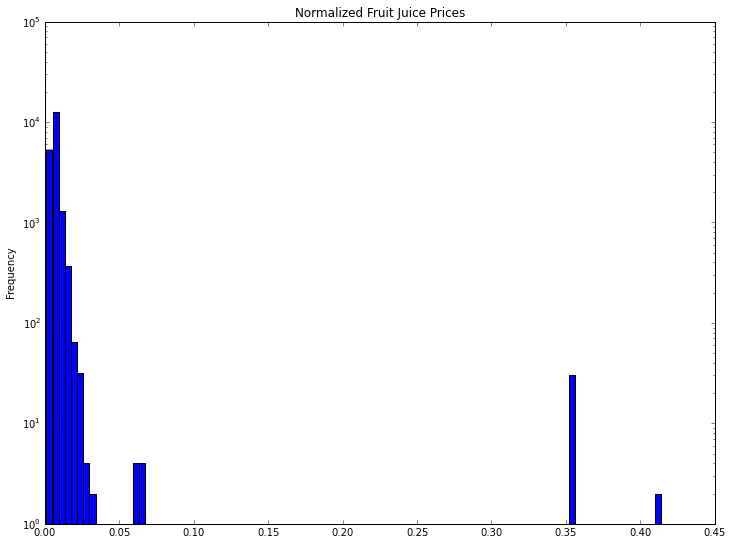

In [7]:
#Select Fruit Juice
fruitJuice = df[df["p_item_product_lc"]=="Fruit juice"]
#Plot all Fruit Juice normalized prices
fruitJuice.ix[:,"normalized_price"].plot(kind="hist",bins=100, logy=True, title="Normalized Fruit Juice Prices")

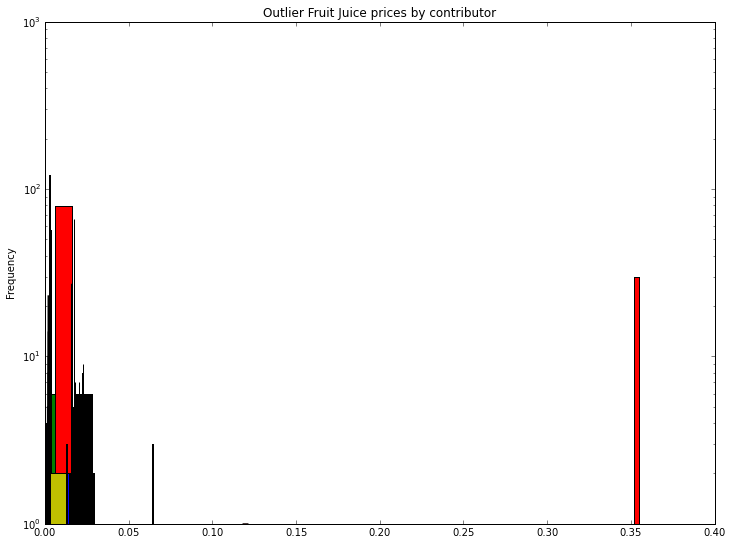

In [8]:
fruitJuiceOutliers= outliers[outliers["p_item_product_lc"]=="Fruit juice"]
for contributor in fruitJuiceOutliers.groupby("u_uuid"):
    contributor[1].loc[:,"normalized_price"].plot(kind="hist",bins=100, logy=True, xlim=(0,.4),title="Outlier Fruit Juice prices by contributor")

Largest outliers in fruit juices seem to be from one contributor who has been submitting the same picture of a damaged can of fruit juice at various angles over the past 2 years. 

#### 2. 
#### i. For the data set, describe some variables that could be sources of sampling bias when estimating price trends in Ghana. Explain why each of these variables could cause sampling bias.

* Location : 
    One sampling bias could come from the locations of the observations.  It could be that contributors are biasing the sample by always going to the same supermarket or mom-and-pop shop.  Furthermore, if we assume such a bias, then taking a simple daily average for each product may overly represent the product prices in the most frequent location.  We could instead take the average of average of prices in specific locations in specific cities.  If the observations are imbalanced, we would see a bias.   

* Product composition of sample: We might want to look at the composition of the sample. i.e..sample by sample is a specific product over/under represented relative to other products.  For example, if normally, one expects on any given day that Coca-Cola bottles make up for 5% of submissions but yet for a specific day they made up 15% of the observations (maybe because contributors did not submit other products as much), then we can expect a bias in our sample.  

* Contributors: Fraudulent submissions and unintentional input mistakes could of course bias the sample.


#### ii. Pick one bias (not u_uuid). Write some code that attempts to estimate the potential amount of sample bias caused by this variable, and describe your methodology.

I picked location. I wanted to see if averaging over the normalized prices per day for each product gives the same result as taking the average of normalized prices per location in each city then averaging over those. The former gives more weight to the locations with the most observations, while the other holds locations on more equal footing. If the observations are equally distributed over the cities and locations we expect no change. On the other hand, we may expect so bias if some locations are over-represented.  
 

Let's define:
* method 1 as the daily average of normalized price of a product
* method 2 as the average of the average normalize price for the product sold in a location in a city for all locations and cities.  

We'll define our bias as (method 2 - method 1) / method 1 

In [9]:
# a function to calculate the bias, we fit a line and take the intercept as our bias
def estimateBias(unbiased=None, biased=None):
    biases = [] 
    unbiased["bias_est"] = (unbiased["mean"]-biased["mean"])/ biased["mean"]
    for prod,prodDf in unbiased.groupby(["p_item_product_lc"]):
        days = [(e - min(prodDf["date"])).days for e in prodDf["date"]] 
        nFit = np.polyfit(days, prodDf["bias_est"], 0)
        l = linregress(days,prodDf["bias_est"])
        # compare constant and order 1 fits
        #print nFit, l.intercept
        biases.append(np.abs(nFit[0]))
    return biases

In [10]:
#Add date column to dataframe
def addDate(dFrame):
    dFrame.loc[:,"date"]= dFrame["t_time"].apply(lambda x : datetime.strptime(x.split(".")[0],"%Y-%m-%d %X").date())
    return dFrame

#remove outliers from dataframe
df = addDate(df.drop(outliers.index))

In [11]:
newDf = pd.DataFrame()
groups = ["p_item_product_lc","city","l_place_name","date"]

#Drop rows with NAN in the columns we're interested in
df = df.dropna(subset = groups)

#find the average daily price for each product for each city and location 
prodCityPlaceDateGrouped = df.groupby(groups, as_index=True)
prodCityPlaceDate = prodCityPlaceDateGrouped["normalized_price"].agg([np.mean])
prodCityPlaceDate = prodCityPlaceDate.reset_index()

# average over those averages (avg of avgs)
prodDateGrouped = prodCityPlaceDate.groupby(["p_item_product_lc","date"])
unbiased = prodDateGrouped["mean"].agg([np.mean])


#find the average daily price aggregated over all cities and locations (simple avg)

biasedGrouped = df.groupby(["p_item_product_lc","date"], as_index=True)
biased = biasedGrouped["normalized_price"].agg([np.mean])

#reset indexes
unbiased = unbiased.reset_index()
biased = biased.reset_index()


maxB = max(estimateBias(unbiased, biased))
meanB = np.mean(estimateBias(unbiased, biased))
print "Average bias in products due to imbalance sampling: %3.2f %%" % meanB
print "Highest bias measured: %3.2f %%" % maxB

Average bias in products due to imbalance sampling: 0.01 %
Highest bias measured: 0.10 %


We see a small average bias across all products, with the maximum being a tenth of a percent.

# Modelling Question


### 1. Create a model that predicts price from various metadata.

#### i. Explain how your model works, and why you chose it.

I have decided to use a random forest regression. A random forest averages over a number of decision trees (where each splitting branch is a feature of our model) trained on different sub-sets of the dataset. 

Decision Trees are able to pick out subtle features in the data (i.e. difference prices of onions bought at supermarkets vs open-markets) at the expense of potentially over-fitting the data. Creating a random selection of tress (a forest) helps to control over-fitting. Averaging over these threes also improves the predictive accuracy.

#### ii. Why did you use the metadata you used?

I used :
   * product: Not much to say there...can't compare apples and oranges...I need the product as a feature.
   * city: I expect variations in price in Metropolitan vs rural cities for many products. 
   * location: SuperMarkets and open markets will most likely offer differing product, but also at different prices.   
   * date: Using dates may allow our model to do some crude price forcasting (if time permits, I may try this.)

I did not use:
* package size, quantity, units: Since I'm predicting normalized price, those features are inheritly included.
* Product brand: I don't have a strong reason to not have included this, although I think the dimensionality of the dataset could increase too much for my model to handle, or it may expose it to over-fitting.  I'll come back to this and include if I have time.
   
#### iii. How can you be sure that you’re not over­fitting the model?

I split my dataset into 2/3 and 1/3 parts. The larger part is my training set while the latter is my testing set.
As epected the model gives a 100% accuracy on my training set ( a sign of potential over-fitting) but it is able to accuratly predict 95 percent of my testing set, which is pretty good. 


In [12]:
#Sort by date 
prodCityPlaceDate = prodCityPlaceDate.sort_values(by="date")

In [13]:
#Isolate predictor variables
X = prodCityPlaceDate.loc[:,groups]

#Transform categorical labels into integers
for group in groups:
        X.loc[:,group] = LabelEncoder().fit_transform(X.loc[:,group])

#Split dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X,prodCityPlaceDate["mean"], test_size=0.33, random_state=42)

#instantiate model 
rfr = RandomForestRegressor(n_estimators=100, bootstrap=False)

#fit
rfr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [14]:
rfr.score(X_train,y_train)

0.99999999954482321

In [15]:
rfr.score(X_test,y_test)

0.94871823594554938